In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from functools import reduce

In [2]:
con = sqlite3.connect("data/gelbooru.db")
cur = con.cursor()
timeformat = "%Y-%m-%d %H:%M:%S"

In [3]:
## Create some useful views for the upcoming analysis.
# Create view that counts the tags grouped by its name.
cur.execute("CREATE TEMP VIEW tag_count AS " +
            "SELECT tag.id AS id, tag.name AS name, COUNT(tags.view) AS count " +
            "FROM tag JOIN tags ON tag.id = tags.tag " +
            "GROUP BY tag.name HAVING tag.name <> '1girl' AND tag.name <> 'solo'")
con.commit()

# General information

Tags used for searching: solo, 1girl, -comic, -4koma, -animated, -sound, -webm, -animated gif, -asian, -photo, -3d

## Some simple numbers

In [4]:
cur.execute("SELECT * FROM view ORDER BY id ASC LIMIT 1")
first_entry = cur.fetchone()
cur.execute("SELECT * FROM view ORDER BY id DESC LIMIT 1")
last_entry = cur.fetchone()
cur.execute("SELECT COUNT(*) FROM view")
total_count = cur.fetchone()[0]
cur.execute("SELECT COUNT(*) FROM tag")
tag_count = cur.fetchone()[0]

In [5]:
print("Id of first post: {} (from {})".format(first_entry[0], first_entry[1]))
print("Id of last post: {} (from {})".format(last_entry[0], last_entry[1]))
first_post_datetime = datetime.strptime(first_entry[1], timeformat)
last_post_datetime = datetime.strptime(last_entry[1], timeformat)
timedelta = last_post_datetime - first_post_datetime
print("Total count: {} (spanning {} days)".format(total_count, timedelta.days))
print("Number of tags: {}".format(tag_count))

Id of first post: 5 (from 2007-07-16 00:20:00)
Id of last post: 3150000 (from 2016-04-26 03:00:24)
Total count: 1212463 (spanning 3207 days)
Number of tags: 213432


## Distribution of posts

In [6]:
cur.execute("SELECT rating.name, COUNT(view) FROM rates JOIN rating ON rates.rating = rating.id GROUP BY rating")
dist_ratings = cur.fetchall()

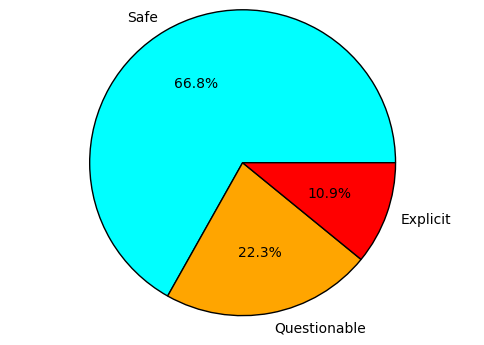

In [7]:
plt.pie([x[1] for x in dist_ratings], labels=[x[0] for x in dist_ratings], 
        colors=["cyan", "orange", "red"], autopct='%1.1f%%')
plt.axis('equal')
plt.show()

# Time series

Watch the data for every full month since the beginning. At the moment this is from Aug 2007 to Mar 2016.

In [8]:
total_months = (last_post_datetime.year - first_post_datetime.year - 1) * 12
total_months += last_post_datetime.month + (12 - first_post_datetime.month) + 1
first_id_of_month = np.empty(total_months, dtype=int)
year = 0
month = 0
index = 0
# Get the first id of each month.
for row in cur.execute("SELECT id, posted FROM view ORDER BY id ASC"):
    date = datetime.strptime(row[1], timeformat)
    if date.year > year:
        year = date.year
        month = 0
    if date.month > month:
        month = date.month
        first_id_of_month[index] = row[0]
        index += 1

In [9]:
# Count the number of uploads.
id_range = list(zip(first_id_of_month[0:-1], first_id_of_month[1:]))
count_per_month = []
for i in range(0, total_months - 1):
    ids = tuple((str(id) for id in id_range[i]))
    cur.execute("SELECT COUNT(*) FROM view WHERE id >= ? AND id < ?", ids)
    count_per_month.append(cur.fetchone())

In [10]:
# Count only safe uploads (no nudes etc.)
id_range = list(zip(first_id_of_month[0:-1], first_id_of_month[1:]))
count_per_month_safe = []
for i in range(0, total_months - 1):
    ids = tuple((str(id) for id in id_range[i]))
    cur.execute("SELECT COUNT(*) FROM view JOIN rates ON view.id = rates.view " +
                "WHERE view.id >= ? AND view.id < ? AND rates.rating = 1", ids)
    count_per_month_safe.append(cur.fetchone())

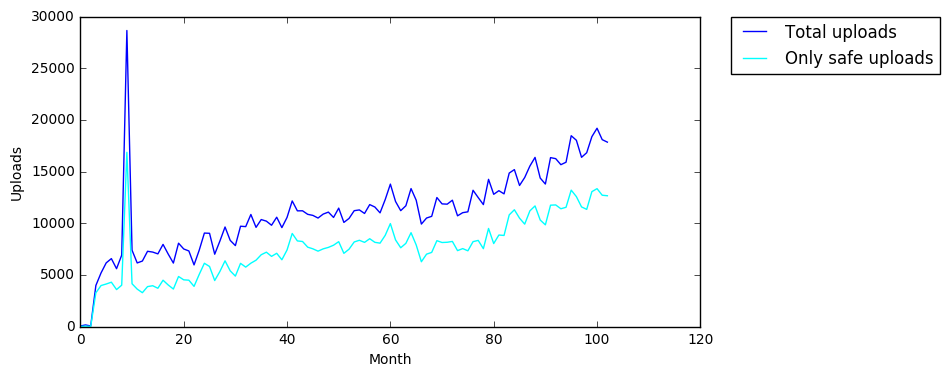

In [11]:
plt.figure(figsize=(8,4))
plt.plot(count_per_month[1:-1], label="Total uploads")
plt.plot(count_per_month_safe[1:-1], label="Only safe uploads", color="cyan")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Month")
plt.ylabel("Uploads")
plt.show()

# Tag analysis

Goal: Find appropriate tags for automatic tagging with neural network.

In [12]:
cur.execute("SELECT tag_count.name, tag_count.count, tag_type.name " +
            "FROM tag_count JOIN categorizes ON tag_count.id = categorizes.tag " +
            "JOIN tag_type ON tag_type.id = categorizes.tag_type " +
            "WHERE count > 20000 ORDER BY count DESC")
top_tags = cur.fetchall()

In [13]:
print("{0:10} {1:>35} - {2:>6}".format("TYPE", "TAG NAME", "COUNT"))
print("-------------------------------------------------------")
for entry in top_tags:
    print("{0[2]:10} {0[0]:>35} - {0[1]:6d}".format(entry))
print("IN TOTAL:", len(top_tags), "TAGS")

TYPE                                  TAG NAME -  COUNT
-------------------------------------------------------
general                              long hair - 562353
general                                breasts - 474336
general                                  blush - 384920
general                                highres - 367095
general                                 female - 321347
general                                  smile - 309188
general                             short hair - 303731
general                      looking at viewer - 287483
copyright                               touhou - 267455
general                              blue eyes - 240885
general                             open mouth - 238594
general                                  skirt - 225126
general                             thighhighs - 218767
general                            blonde hair - 211997
general                               red eyes - 195450
general                             brown hair -

In [14]:
tag_count = np.array([entry[1] for entry in top_tags])
print("Mean:", np.mean(tag_count))
print("Standard derivation:", np.std(tag_count))

Mean: 72823.9223301
Standard derivation: 80927.2597798


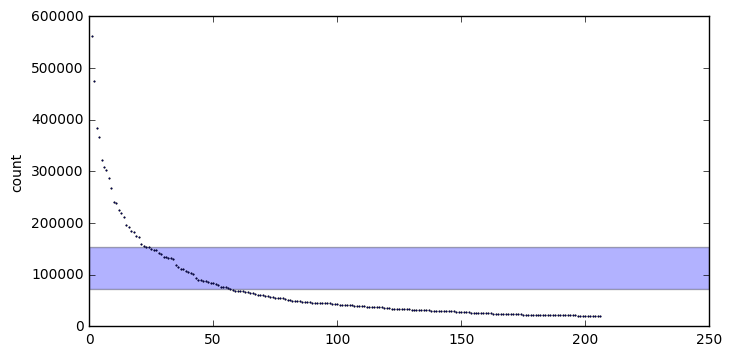

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(tag_count) + 1), tag_count, "bo", markersize=1)
plt.axhspan(np.mean(tag_count), np.mean(tag_count) + np.std(tag_count), alpha=0.3)
plt.ylabel("count")
plt.show()

Idea. Define categories by these tags:
* nude
* school uniform
* swimsuit
* japanese clothes
* dress
* shorts, shirt

*Check to what extend the id's for these tags are disjoint.*

Maybe use some additional features:
* loli
* cat ears, cat tail

*These tags do not to be disjoint.*